In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import timestring
#from bokeh.plotting import figure
from bokeh.charts import Histogram, Bar, Scatter
from bokeh.io import output_notebook, push_notebook, show

import seaborn as sns
sns.set(style="darkgrid")
import folium

%matplotlib inline
output_notebook()

/Users/virginiedo/miniconda2/lib/python2.7/site-packages/bokeh/util/deprecation.py:34: BokehDeprecationWarning: 
The bokeh.charts API has moved to a separate 'bkcharts' package.

This compatibility shim will remain until Bokeh 1.0 is released.
After that, if you want to use this API you will have to install
the bkcharts package explicitly.

  warn(message)


Loading BokehJS ...

In [4]:
df = pd.read_csv('data/311_Fireworks_Complaints.csv',parse_dates=['Created Date', 'Closed Date'],
     infer_datetime_format=True)
df.head(5)

NameError: name 'pd' is not defined

# Data cleanup

In [3]:
df.isnull().sum()

Unique Key                           0
Created Date                         0
Closed Date                          2
Agency                               0
Agency Name                          0
Complaint Type                       0
Descriptor                        1516
Location Type                        0
Incident Zip                         0
Incident Address                   695
Street Name                        695
Cross Street 1                     692
Cross Street 2                     692
Intersection Street 1              826
Intersection Street 2              826
Address Type                         0
City                                 0
Landmark                          1514
Facility Type                        1
Status                               0
Due Date                             0
Resolution Action Updated Date       0
Community Board                      0
Borough                              0
X Coordinate (State Plane)          14
Y Coordinate (State Plane

In [4]:
delete_columns = ["Intersection Street 1", "Intersection Street 2", "Address Type", "Landmark", "Facility Type",\
                  "Status", "X Coordinate (State Plane)", "Y Coordinate (State Plane)", "Park Facility Name",\
                  "Park Borough", "School Name", "School Number", "School Region", "School Code",\
                  "School Phone Number", 
                  "School Address", "School City", "School State", "School Zip", "School Not Found",\
                  "School or Citywide Complaint", "Vehicle Type", "Taxi Company Borough", "Taxi Pick Up Location",\
                  "Bridge Highway Name", "Bridge Highway Direction", "Road Ramp", "Bridge Highway Segment",\
                  "Garage Lot Name", "Ferry Direction", "Ferry Terminal Name","Due Date", \
                  "Resolution Action Updated Date","Incident Address","Street Name","Cross Street 1","Cross Street 2",\
                  "Location Type"]

df.drop(delete_columns, axis=1, inplace=True)
df.shape

(1517, 14)

In [5]:
#Drop NAs in several categories and print new null sums
df = df.dropna(subset=['Latitude',"Longitude","Complaint Type", "Incident Zip"], how='any')
df.isnull().sum()

Unique Key            0
Created Date          0
Closed Date           2
Agency                0
Agency Name           0
Complaint Type        0
Descriptor         1503
Incident Zip          0
City                  0
Community Board       0
Borough               0
Latitude              0
Longitude             0
Location              0
dtype: int64

In [6]:
#Change incident_zip column datatype from float to str
#to map with GeoJSON
df['Incident Zip'] = df['Incident Zip'].astype(int)
df['Incident Zip'] = df['Incident Zip'].astype(str)
df['Incident Zip'].dtype

dtype('O')

In [7]:
#Cleaning column name syntax
df.columns = ['unique_key','created_date', 'closed_date', 'agency', 'agency_name','complaint_type',\
                    'descriptor', 'incident_zip', 'city','community_board', 'borough', 'latitude', 'longitude',\
                    'location']
df.head(5)

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,city,community_board,borough,latitude,longitude,location
0,30748075,2015-06-01 14:38:25,2015-06-01 14:47:30,NYPD,New York City Police Department,Illegal Fireworks,NaN,10305,STATEN ISLAND,01 STATEN ISLAND,STATEN ISLAND,40.612589,-74.075683,"(40.61258861162453, -74.07568315408508)"
1,30762899,2015-06-03 23:54:54,2015-06-04 01:43:03,NYPD,New York City Police Department,Illegal Fireworks,NaN,11414,HOWARD BEACH,10 QUEENS,QUEENS,40.649413,-73.835472,"(40.6494132503695, -73.83547217816559)"
2,30771683,2015-06-04 20:37:59,2015-06-04 22:45:15,NYPD,New York City Police Department,Illegal Fireworks,NaN,10305,STATEN ISLAND,01 STATEN ISLAND,STATEN ISLAND,40.612589,-74.075683,"(40.61258861162453, -74.07568315408508)"
3,30771690,2015-06-05 00:22:08,2015-06-05 01:15:13,NYPD,New York City Police Department,Illegal Fireworks,NaN,10002,NEW YORK,03 MANHATTAN,MANHATTAN,40.715795,-73.990560,"(40.7157948361671, -73.99055967847579)"
4,30783483,2015-06-06 09:22:22,2015-06-06 09:50:29,NYPD,New York City Police Department,Illegal Fireworks,NaN,11204,BROOKLYN,11 BROOKLYN,BROOKLYN,40.616028,-73.998729,"(40.61602804353828, -73.99872852393159)"


In [8]:
df.to_csv('cleaned_fireworks.csv')

# Data analysis

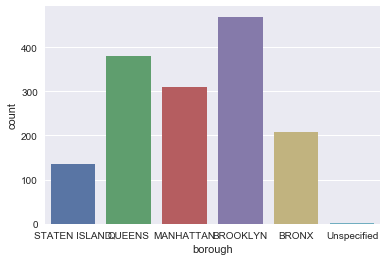

In [9]:
#count by borough
agency_count = sns.countplot(x="borough", data=df)

In [10]:
# List of months by number.
# timestamps = [timestring.parse(row[2]) for row in df.itertuples()]
df['month'] = df['created_date'].apply(lambda x: x.month)
months = [row.month for row in df.itertuples()]
#print(sorted(months))

# Define the plot
plot = Histogram(months, xlabel='Months', ylabel='Frequency', title='Firework Complaints by Month')
handle = show(plot, notebook_handle=True)  # Show the figure.

In [3]:
df['hour'] = df['created_date'].apply(lambda x: x.hour)

hour_counts = df.groupby(['hour'],sort = True).count()
# Plot complaint counts
hour_counts.plot(kind = 'area', stacked = False,
                  color = 'darkorange', linewidth = 2, legend = False)
plt.tick_params(axis = 'both', which = 'major', labelsize = 18)
plt.title('Number of complaints / hour of the day\n')
plt.xlabel('')
plt.ylabel('Number of complaints')

NameError: name 'df' is not defined

# Choropleth map

In [1]:
#choropleth map
zipcode_geo = r'data/ZIPNYC.geojson'

zip_data = df["incident_zip"].value_counts()
zip_count = pd.DataFrame(zip_data).reset_index()
zip_count.columns = ["postalCode","count"]


#Let Folium determine the scale
map = folium.Map(location=[40.7128, -74.0059], zoom_start=10)
map.choropleth(geo_path=zipcode_geo, data=zip_count,
             columns=["postalCode","count"],
             key_on='feature.properties.postalCode',
             fill_color='BuPu', fill_opacity=0.7, line_opacity=0.2)

map.save('html/fireworks_by_zipcode.html')
map

NameError: name 'df' is not defined

# Cluster map

In [2]:
from folium import plugins

marker_cluster = folium.MarkerCluster().add_to(map)
for name, row in df.iterrows():
    folium.Marker([row["latitude"], row["longitude"]], popup="{0}".format(row["incident_zip"])).add_to(marker_cluster)
    
map.save('html/firework_cluster_map.html')
map

NameError: name 'folium' is not defined